# Dataset multi-track audio and aligned MIDI for music source separation and multi-instrument automatic transcription
http://www.slakh.com/

slack_utils: https://github.com/ethman/slakh-utils/tree/master

(complex valued CNN: https://arxiv.org/pdf/1602.09046.pdf)
Variationnal autoencoder for voice separation: https://arxiv.org/pdf/1810.13104.pdf

Unet architecture for audio source separation: 
https://dcyoung.github.io/post-spleeter-pytorch/
https://archives.ismir.net/ismir2019/latebreaking/000036.pdf 

# First midi manipulations

In [4]:
from mido import MidiFile, MidiTrack

# Opening the original MIDI sequence
input_midi = MidiFile('./AUD_HNG0138.mid')

# Creating the destination file object
output_midi = MidiFile()

# Copying the time metrics between both files
output_midi.ticks_per_beat = input_midi.ticks_per_beat


for original_track in input_midi.tracks:

    new_track = MidiTrack()

    # for msg in original_track:
    #     new_track.append(msg)

    # MIDI files are multitrack. Here we append
    # the new track with mapped notes to the output file
    output_midi.tracks.append(original_track)
    break
    

# Finally, save the mapped file to disk
output_midi.save('./Minus_1.mid')

In [5]:
# conda install -c cogsci pygame
import pygame

def play_music(midi_filename):
  '''Stream music_file in a blocking manner'''
  clock = pygame.time.Clock()
  pygame.mixer.music.load(midi_filename)
  pygame.mixer.music.play()
  while pygame.mixer.music.get_busy():
    clock.tick(30) # check if playback has finished
    
midi_filename = 'Minus_1.mid'

# mixer config
freq = 44100  # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2  # 1 is mono, 2 is stereo
buffer = 1024   # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

# optional volume 0 to 1.0
pygame.mixer.music.set_volume(0.8)

# listen for interruptions
try:
  # use the midi file you just saved
  play_music(midi_filename)
except KeyboardInterrupt:
  # if user hits Ctrl/C then exit
  # (works only in console mode)
  pygame.mixer.music.fadeout(1000)
  pygame.mixer.music.stop()
  raise SystemExit

AttributeError: 'tuple' object has no attribute 'tb_frame'

# Preprocessing

## Short time fourier transform

In [1]:
import librosa
import numpy as np
y, sr = librosa.load('LEXPA.wav')
S = np.abs(librosa.stft(y))
S, len(S), len(S[0])

1.1920929e-07

In [3]:
stft = librosa.stft(y)
D.shape

(1025, 6442)

In [4]:
D[:,1]

array([-2.1103281e-03+0.0000000e+00j, -2.2224309e-03-1.2983364e-05j,
       -8.2822368e-03-5.8005168e-03j, ..., -1.4068502e-06+4.8062827e-08j,
       -1.8695433e-08+1.3741354e-06j,  1.4609151e-06+0.0000000e+00j],
      dtype=complex64)

In [10]:
S = np.transpose(S)
len(S)

6440

In [4]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
last_beat = beats[-1]
tempo, beats

(143.5546875,
 array([   3,   20,   38,   56,   73,   90,  108,  125,  142,  159,  177,
         194,  212,  230,  248,  265,  282,  299,  317,  335,  352,  370,
         387,  404,  421,  439,  456,  474,  492,  509,  526,  543,  561,
         578,  596,  614,  631,  649,  666,  684,  701,  719,  736,  754,
         771,  789,  805,  823,  841,  859,  876,  894,  911,  928,  945,
         963,  980,  997, 1014, 1032, 1050, 1068, 1085, 1102, 1119, 1137,
        1154, 1173, 1194, 1215, 1233, 1250, 1267, 1285, 1306, 1323, 1339,
        1355, 1372, 1389, 1410, 1430, 1447, 1464, 1482, 1500, 1520, 1538,
        1557, 1573, 1592, 1610, 1626, 1644, 1661, 1678, 1694, 1713, 1730,
        1748, 1765, 1782, 1800, 1816, 1833, 1851, 1869, 1887, 1906, 1923,
        1940, 1957, 1975, 1992, 2010, 2028, 2045, 2062, 2079, 2097, 2115,
        2132, 2150, 2167, 2183, 2201, 2219, 2237, 2254, 2272, 2290, 2307,
        2324, 2341, 2359, 2375, 2393, 2411, 2429, 2447, 2464, 2480, 2499,
        2517, 2534, 2552

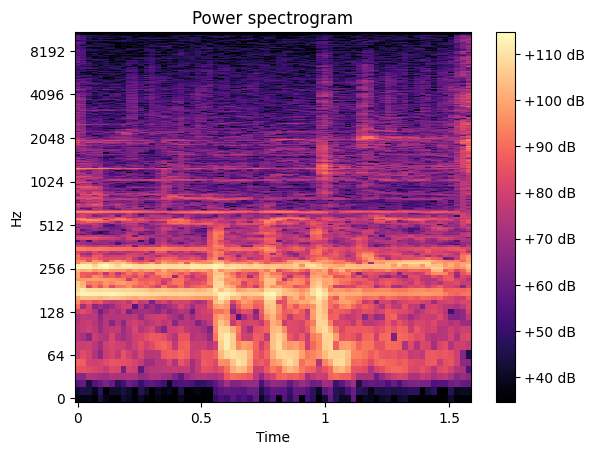

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
t_S = np.transpose(S[beats[i]:beats[i+4]])
img = librosa.display.specshow(librosa.amplitude_to_db(t_S,
                                                       ref=0),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [20]:
print(librosa.amplitude_to_db(t_S, ref=0))

[[37.444275 37.43572  38.16318  ... 34.721    34.721    34.721   ]
 [41.65065  44.419037 44.376823 ... 39.211266 40.092285 40.31261 ]
 [56.70917  59.3475   43.702644 ... 62.316616 58.997578 58.216877]
 ...
 [34.721    34.721    34.721    ... 34.721    34.721    34.721   ]
 [34.721    34.721    34.721    ... 34.721    34.721    34.721   ]
 [34.721    34.721    34.721    ... 34.721    34.721    34.721   ]]


In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
track_path = 'babyslakh_16k/babyslakh_16k/Track00001/mix.wav'
audio_file = tf.io.read_file(track_path)
audio_file = tf.squeeze(audio_file, axis=-1)
waveform, sr = tf.audio.decode_wav(audio_file)
# Zero-padding for an audio waveform with less than 16,000 samples.
input_len = 16000
waveform = waveform
print(tf.shape(waveform))
# Cast the waveform tensors' dtype to float32.
waveform = tf.cast(waveform, dtype=tf.float32)
# Convert the waveform to a spectrogram via a STFT.
spectrogram = tf.signal.stft(
    waveform, frame_length=256, frame_step=128)
# Obtain the magnitude of the STFT.
spectrogram = tf.abs(spectrogram)
spectrogram = spectrogram[..., tf.newaxis]

2024-01-08 21:35:39.011142: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-01-08 21:35:39.519107: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at audio_kernels.cc:130 : OUT_OF_RANGE: Read less bytes than requested


OutOfRangeError: {{function_node __wrapped__IO>AudioReadableInit_device_/job:localhost/replica:0/task:0/device:CPU:0}} Read less bytes than requested [Op:IO>AudioReadableInit]

## Segmenting image (dividing it in same size images)

In [ ]:
import cv2

def sliding_window(image, step_size, window_size):
    # get the window and image sizes
    h, w = window_size
    image_h, image_w = image.shape[:2]

    # loop over the image, taking steps of size `step_size`
    for y in range(0, image_h, step_size):
        for x in range(0, image_w, step_size):
            # define the window
            window = image[y:y + h, x:x + w]
            # if the window is below the minimum window size, ignore it
            if window.shape[:2] != window_size:
                continue
            # yield the current window
            yield (x, y, window)

## Scaling & reshaping

In [ ]:
def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

# Model for isolating drums

In [6]:
from tensorflow.keras import layers, Model

input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

2024-01-05 21:10:36.724357: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 21:10:38.459165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 21:10:38.459311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 21:10:38.659617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 21:10:39.174622: I tensorflow/core/platform/cpu_feature_guar

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 32)        9248  

2024-01-05 21:10:46.276511: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-05 21:10:47.364361: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-05 21:10:47.364405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-05 21:10:47.367941: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-05 21:10:47.367983: I external/local_xla/xla/stream_executor

In [ ]:
autoencoder.fit(
    x=train_data,
    y=train_data_drum,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

# GAN